In [ ]:
# Instalación de librerias
import pandas as pd
import numpy as np
import sys
!{sys.executable} -m pip install pandas-profiling
!{sys.executable} -m pip install chardet
!{sys.executable} -m pip install num2words
!pip install contractions

from num2words import num2words
import re, string, unicodedata
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix
import chardet


from sklearn.base import BaseEstimator, ClassifierMixin

import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 8.7 MB/s eta 0:00:00


In [ ]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')
stopwords_set = set(stopwords.words("spanish"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Revision de los datos

In [ ]:
df = pd.read_excel("/content/drive/MyDrive/BI Datasets/ODScat_345.xlsx")
df_mutable = df.copy()  # Usar este para operaciones fuera de pipeline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df

,Textos_espanol,sdg
0,"Por ejemplo, el nÃºmero de consultas externas ...",3
1,"En 2007, el gobierno central financió directam...",3
2,"Claramente, hay muchos otros factores en juego...",3
3,"Por ejemplo, el estado australiano de Victoria...",3
4,"El consumo anual de alcohol se estima en 15,7 ...",3
...,...,...
4044,"Para ello, identificará las cuestiones de géne...",5
4045,La participación de las mujeres en roles de li...,5
4046,"Según el WEF, según las tendencias de 2016, po...",5
4047,"Sirve como recurso y foro para las agencias, c...",5


In [ ]:
df.describe()

,sdg
count,4049.000000
mean,4.051124
std,0.814338
min,3.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


In [ ]:
df.shape


(4049, 2)

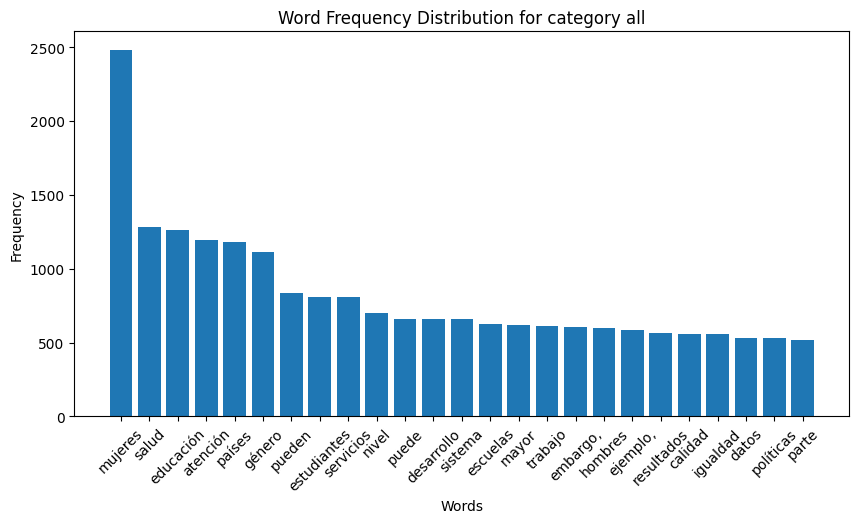

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter


def graph_frecuency_distribution(text: str, category):

  # Tokenize and count word frequencies
  words = text.lower().split()
  filtered_words = [word for word in words if word not in stopwords_set]

  word_freq = Counter(filtered_words)


  top_words = dict(word_freq.most_common(25))

  words, freqs = zip(*top_words.items())

  # Histogram
  plt.figure(figsize=(10, 5))
  plt.bar(words, freqs)
  plt.xlabel('Words')
  plt.ylabel('Frequency')
  plt.title(f'Word Frequency Distribution for category {category}')
  plt.xticks(rotation=45)
  plt.show()


text_data = " ".join(df['Textos_espanol'].astype(str))
graph_frecuency_distribution(text_data, "all")

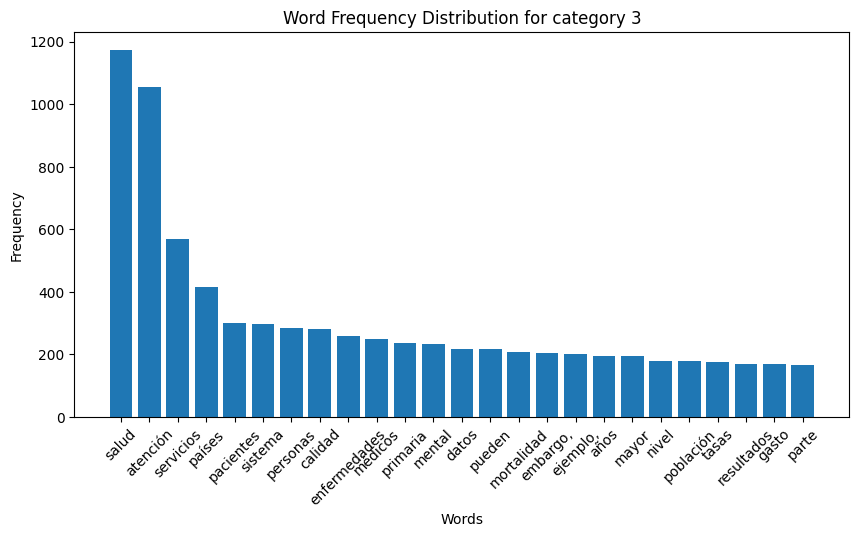

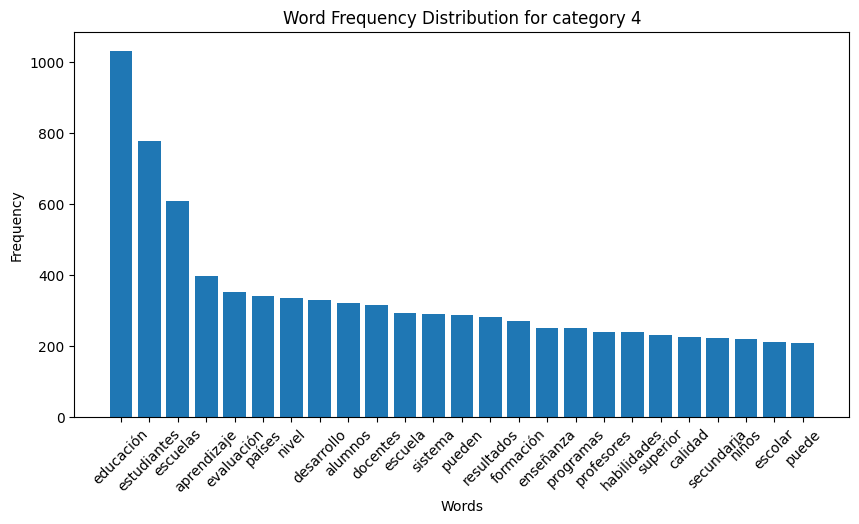

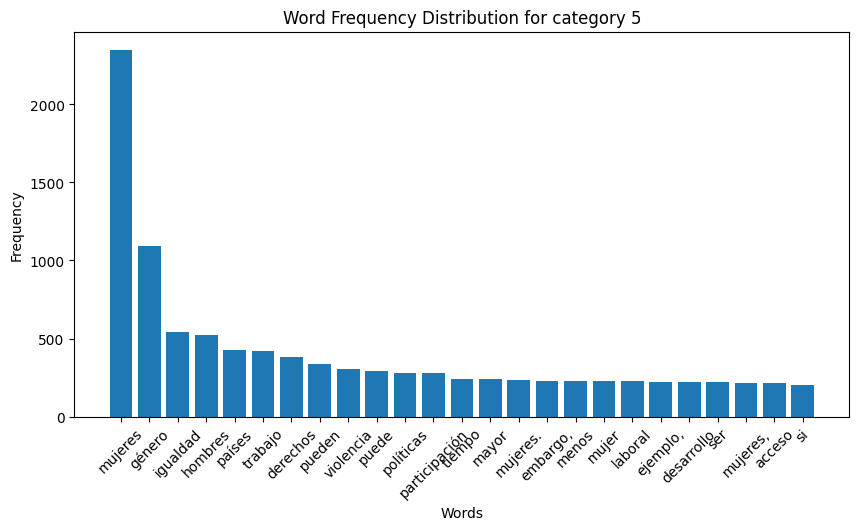

In [ ]:
grouped = df.groupby('sdg')['Textos_espanol']
grouped_text = grouped.apply(lambda texts: ' '.join(texts))

for category, text in grouped_text.items():
  graph_frecuency_distribution(text, category)

In [ ]:
grouped.describe()

,count,unique,top,freq
sdg,,,,
3,1244,1244,"Por ejemplo, el nÃºmero de consultas externas ...",1
4,1354,1354,"En promedio, en los países de la OCDE en 2016,...",1
5,1451,1451,"Sin embargo, un plan de negocios preparado jui...",1


In [ ]:
df.isnull().sum()

,0
Textos_espanol,0
sdg,0


# Preparacion de Datos

In [ ]:
from nltk.stem.snowball import SpanishStemmer

spanish_stemmer = SpanishStemmer()

In [ ]:
ISO_SPECIFIC_CHAR = "Ã"

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    return [word.lower() for word in words]

def number_to_text(words: list[str]):
    result = []
    composed = [word_tokenize(num2words(int(word), lang='es')) if word.isdigit() else [word] for word in words]
    for sublist in composed:
      for word in sublist:
        result.append(word)
    return result

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        if word is not None:
          new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
          new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        if word is not None:
            new_word = re.sub(r'[^\w\s]', '', word)
            if new_word != '':
                new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    return [word for word in words if word not in stopwords_set]

def _fix_partial_encoding_text(text: str):
  if ISO_SPECIFIC_CHAR in text:
    return text.encode('ISO-8859-1', errors='replace').decode('UTF-8', errors='replace')
  return text

def fix_partial_encoding(words: list[str]):
  return [_fix_partial_encoding_text(word) for word in words]

def stem_words(words: list[str]):
  return [spanish_stemmer.stem(word) for word in words]

def preprocessing(words: list[str]):
    words = number_to_text(words)
    words = fix_partial_encoding(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = stem_words(words)
    return words

In [ ]:
def join_words(words: list[str]):
  return " ".join(words)

# Manual model creation area

In [ ]:

df_mutable['words'] = df_mutable['Textos_espanol'].apply(word_tokenize)
df_mutable['words'] = df_mutable['words'].dropna()

In [ ]:
df_mutable['words'] = df_mutable['words'].apply(preprocessing)

In [ ]:
df_mutable

,Textos_espanol,sdg,words
0,"Por ejemplo, el nÃºmero de consultas externas ...",3,"[ejempl, numer, consult, extern, especial, tre..."
1,"En 2007, el gobierno central financió directam...",3,"[dos, mil, siet, gobiern, central, financ, dir..."
2,"Claramente, hay muchos otros factores en juego...",3,"[clar, factor, jueg, particul, varied, barrer,..."
3,"Por ejemplo, el estado australiano de Victoria...",3,"[ejempl, australian, victori, cre, agenci, pro..."
4,"El consumo anual de alcohol se estima en 15,7 ...",3,"[consum, anual, alcohol, estim, 157, litr, año..."
...,...,...,...
4044,"Para ello, identificará las cuestiones de géne...",5,"[ello, identific, cuestion, gener, destac, mal..."
4045,La participación de las mujeres en roles de li...,5,"[particip, mujer, rol, liderazg, dentr, legisl..."
4046,"Según el WEF, según las tendencias de 2016, po...",5,"[segun, wef, segun, tendenci, dos, mil, diecis..."
4047,"Sirve como recurso y foro para las agencias, c...",5,"[sirv, recurs, for, agenci, objet, logr, enfoq..."


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# Cambiar ngram_range a (1,2) si usando KNN

vectorizer = TfidfVectorizer(ngram_range=(1,3))
series = df_mutable['words'].apply(join_words)
tfidf_matrix = vectorizer.fit_transform(series)

In [ ]:
y = df_mutable['sdg']      # Labels as a Series

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, y, test_size=0.2, random_state=42)

## ( Quitar comentario al modelo a entrenar, usar pre-entrenados si no se desea cambiar )

In [ ]:
from sklearn.linear_model import LogisticRegression

# Descomentar para entrenar usando LogisticRegression

# model = LogisticRegression()

# model.fit(X_train, y_train)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Descomentar para entrenar usando KNN

# model = KNeighborsClassifier(n_neighbors=10)

# model.fit(X_train, y_train)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 5)
}

# Descomentar para entrenar usando RandomForest con RandomSearch (lento)

rf = RandomForestClassifier()
model = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=42)

model.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': [None, 10, 20, 30],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7bb08196eb60>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7bb08196d510>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7bb08196f4c0>},
                   random_state=42, scoring='accuracy')

In [ ]:
# Correr predicciones y revisar rendimiendo de modelo (KNN tiende a tardarse bastante)

y_prob = model.predict_proba(X_test)

y_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

# Accuracy
accuracy = accuracy_score(y_test, y_pred)

# Precision
precision = precision_score(y_test, y_pred, average='micro')

# Recall
recall = recall_score(y_test, y_pred, average='micro')

# F1-Score
f1 = f1_score(y_test, y_pred, average='micro')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# ROC-AUC Score (requires predicted probabilities)
roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr', average='micro')

# Print results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print("Confusion Matrix:")
print(conf_matrix)
print(f"ROC-AUC Score: {roc_auc:.2f}")


Accuracy: 0.97
Precision: 0.97
Recall: 0.97
F1-Score: 0.97
Confusion Matrix:
[[238   5   7]
 [  1 264   3]
 [  3   8 281]]
ROC-AUC Score: 1.00


In [ ]:
import joblib

# joblib.dump(model, '/content/drive/MyDrive/BI Models/Proyecto1/model-logistic.pkl')
# model = joblib.load('/content/drive/MyDrive/BI Models/Proyecto1/model-logistic.pkl')

# joblib.dump(model, '/content/drive/MyDrive/BI Models/Proyecto1/model-knn.pkl')
# model = joblib.load('/content/drive/MyDrive/BI Models/Proyecto1/model-knn.pkl')

# joblib.dump(model, '/content/drive/MyDrive/BI Models/Proyecto1/model-forest.pkl')
# model = joblib.load('/content/drive/MyDrive/BI Models/Proyecto1/model-forest.pkl')

In [ ]:
# df_mutable['vector'].apply(lambda x: model.predict(x.reshape(1, -1))[0])

# Convertir a transformadores para armar pipeline

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
import re

class ToLowercaseTransformer(BaseEstimator, TransformerMixin):
    def transform(self, X, y=None):
      return X.apply(to_lowercase)

    def fit(self, X, y=None):
        return self

class Remove_non_ascii_Transformer(BaseEstimator, TransformerMixin):
    def transform(self, X, y=None):
      return X.apple(remove_non_ascii)

    def fit(self, X, t=None):
      return self

class NumberToTextTransformer(BaseEstimator, TransformerMixin):
    def transform(self, X, y=None):
      return X.apply(number_to_text)

    def fit(self, X, y=None):
        return self

class RemovePunctuationTransformer(BaseEstimator, TransformerMixin):
    def transform(self, X, y=None):
      return X.apply(remove_punctuation)

    def fit(self, X, y=None):
        return self

class RemoveStopwordsTransformer(BaseEstimator, TransformerMixin):
    def transform(self, X, y=None):
      return X.apply(remove_stopwords)

    def fit(self, X, y=None):
        return self

class FixPartialEncodingTransformer(BaseEstimator, TransformerMixin):
    def transform(self, X, y=None):
      return X.apply(fix_partial_encoding)

    def fit(self, X, y=None):
        return self

class StemWordsTransformer(BaseEstimator, TransformerMixin):
    def transform(self, X, y=None):
      return X.apply(stem_words)

    def fit(self, X, y=None):
        return self

class TokenizerTransformer(BaseEstimator, TransformerMixin):
    def transform(self, X, y=None):
        # Apply word_tokenize to each entry in the dataframe column
        return X.apply(word_tokenize)

    def fit(self, X, y=None):
        return self

# Convertir a un pipeline de entrada Dataframe y salida Dataframe con nueva columna

In [ ]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class CreateTokenColumnTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column_name, transformer, new_column_name):
        self.column_name = column_name
        self.transformer = transformer
        self.new_column_name = new_column_name

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        print("Creating token column...")
        transformed_column = self.transformer.fit_transform(X[self.column_name])
        X_transformed = X.copy()
        X_transformed[self.new_column_name] = transformed_column
        print("Token column created!")
        return X_transformed


In [ ]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class VectorizeTokenColumnTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column_name, vectorizer, new_column_name):
        self.column_name = column_name
        self.vectorizer = vectorizer
        self.new_column_name = new_column_name

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        print("Creating vector column...")
        transformed_column = X[self.column_name].apply(join_words)
        vectorizer_matrix = self.vectorizer.fit_transform(series)
        X_transformed = X.copy()
        X_transformed[self.new_column_name] = list(vectorizer_matrix.toarray())
        print("Vector column created!")
        return X_transformed


In [ ]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression

class LogisticRegressionTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column_name, model, new_column_name):
        self.column_name = column_name
        self.model = model
        self.new_column_name = new_column_name

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        print("Predicting...")
        X_transformed = X.copy()
        X_transformed[self.new_column_name] = X[self.column_name].apply(lambda x: model.predict(x.reshape(1, -1))[0])
        print("Prediction done")
        return X_transformed

In [ ]:

class RemoveExtraColumnsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.drop(self.columns, axis=1)

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

text_processing_pipeline = Pipeline([
    ('tokenize', TokenizerTransformer()),  # Tokenize text
    ('fix_partial_encoding', FixPartialEncodingTransformer()),
    ('remove_punctuation', RemovePunctuationTransformer()),
    ('number_to_text', NumberToTextTransformer()),
    ('to_lowercase', ToLowercaseTransformer()),
    ('remove_stopwords', RemoveStopwordsTransformer()),
    ('stem_words', StemWordsTransformer()),
])

# Cambiar ngram_range a (1,2) si se usa KNN
pipeline = Pipeline([
  ('text_processing', CreateTokenColumnTransformer(column_name='Textos_espanol', new_column_name='tokens', transformer=text_processing_pipeline)),
  ('vectorizing', VectorizeTokenColumnTransformer(column_name='tokens', new_column_name='vector', vectorizer=TfidfVectorizer(ngram_range=(1, 3)))),
  ('predicting', LogisticRegressionTransformer(column_name='vector', new_column_name='prediction', model=model)),
  ('cleanup', RemoveExtraColumnsTransformer(columns=['tokens', 'vector']))
])


In [ ]:
# NOTE: sdg no es necesario, pipeline es solo para prediccion. Recomendado probar con datos ligeros si modelo es tardio en prediccion (KNN)
res = pipeline.fit_transform(df)
res

Creating token column...
Token column created!
Creating vector column...
Vector column created!
Predicting...
Prediction done


,Textos_espanol,sdg,prediction
0,"Por ejemplo, el nÃºmero de consultas externas ...",3,3
1,"En 2007, el gobierno central financió directam...",3,3
2,"Claramente, hay muchos otros factores en juego...",3,3
3,"Por ejemplo, el estado australiano de Victoria...",3,3
4,"El consumo anual de alcohol se estima en 15,7 ...",3,3
...,...,...,...
4044,"Para ello, identificará las cuestiones de géne...",5,5
4045,La participación de las mujeres en roles de li...,5,5
4046,"Según el WEF, según las tendencias de 2016, po...",5,5
4047,"Sirve como recurso y foro para las agencias, c...",5,5


In [ ]:
import joblib

# joblib.dump(pipeline, '/content/drive/MyDrive/BI Models/Proyecto1/pipeline-logistic.pkl')
# pipeline = joblib.load('/content/drive/MyDrive/BI Models/Proyecto1/pipeline-logistic.pkl')

# joblib.dump(pipeline, '/content/drive/MyDrive/BI Models/Proyecto1/pipeline-knn.pkl')
# pipeline = joblib.load('/content/drive/MyDrive/BI Models/Proyecto1/pipeline-knn.pkl')

# joblib.dump(pipeline, '/content/drive/MyDrive/BI Models/Proyecto1/pipeline-forest.pkl')
# pipeline = joblib.load('/content/drive/MyDrive/BI Models/Proyecto1/pipeline-forest.pkl')